In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
LOCAL_FAST_AI = '/Users/krishnakalyan3/Educational/FastAI/fastai/'
AWS_FAST_AI = '/home/ubuntu/fastai'
sys.path.append(AWS_FAST_AI)

In [3]:
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import *
from fastai.dataset import * 
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = '/home/ubuntu/Plant/data_seg/'

In [57]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=.02)
n, len(val_idxs)

(4750, 95)

In [6]:
f_model = resnet50
sz=250
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)

In [8]:
data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels.csv',
                                    tfms=tfms, val_idxs=[0], test_name='test', bs=64)

In [11]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


A Jupyter Widget

 75%|███████▍  | 56/75 [00:03<00:01, 15.80it/s, loss=14.6]


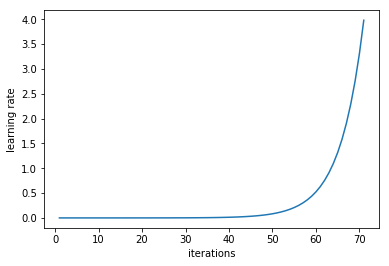

In [12]:
lrf=learn.lr_find()
learn.sched.plot_lr()

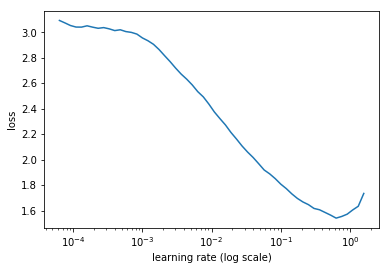

In [13]:
learn.sched.plot()

In [21]:
learn.precompute=False
lr = 1e-1/2
learn.fit(0.002, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.235992   0.308529   1.0       
    1      0.838575   0.485022   1.0                       
    2      0.688456   0.361709   1.0                       



[0.36170864, 1.0]

In [22]:
learn.unfreeze()
lr=np.array([lr/18,lr/6,lr/2])
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.578964   0.085431   1.0       
    1      0.297616   0.030622   1.0                       
    2      0.283636   0.018444   1.0                       
    3      0.223895   0.002299   1.0                       
    4      0.159378   0.001577   1.0                       
    5      0.139534   0.00487    1.0                       
    6      0.179635   0.005542   1.0                       
    7      0.157002   0.008095   1.0                       
    8      0.153342   0.101846   1.0                       
    9      0.130131   0.005877   1.0                       
    10     0.099488   0.013563   1.0                        
    11     0.078317   0.007833   1.0                        
    12     0.074105   0.007501   1.0                        
    13     0.065118   0.005014   1.0                        



[0.0050144196, 1.0]

In [23]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=4)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      0.081708   0.06997    1.0       
    1      0.07793    0.010083   1.0                        
    2      0.113374   0.060834   1.0                        
    3      0.11215    0.000601   1.0                       
    4      0.117128   0.018132   1.0                       
    5      0.082844   0.002017   1.0                        
    6      0.063342   0.144132   1.0                        
    7      0.047243   0.040238   1.0                        
    8      0.048133   0.033265   1.0                        
    9      0.039196   0.026241   1.0                        
    10     0.066818   0.01653    1.0                        
    11     0.076769   0.277777   1.0                        
    12     0.08717    0.262033   1.0                        
    13     0.111331   0.699851   0.0                        
    14     0.082359   0.002069   1.0                        
    15     0.071959   0.005472   1.0       

[0.071485519, 1.0]

In [26]:
learn.save(f'resnet_50_{sz}')

# Test Predictions

In [40]:
log_preds_test = learn.predict(is_test=True)
log_preds_test = np.argmax(log_preds_test, axis=1)
probs = np.exp(log_preds_test)

In [41]:
preds_classes = [data.classes[i].replace("_", " ") for i in log_preds_test]
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv(PATH + 'submission_2.csv', index=False)

In [58]:
def load_weight_predict(PATH, weight_name):
    f_model = resnet50
    sz = 250

    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)

    data = ImageClassifierData.from_csv(PATH, folder='train', test_name='test', csv_fname=f'{PATH}labels.csv',
                                        tfms=tfms, bs=64)
    learn = ConvLearner.pretrained(f_model, data, precompute=False)
    learn.unfreeze()
    learn.load(weight_name)

    log_preds_test = learn.predict(is_test=True)
    log_preds_test = np.argmax(log_preds_test, axis=1)
    probs = np.exp(log_preds_test)
    return probs

In [60]:
probs = load_weight_predict(PATH, 'resnet_50_250')

In [61]:
def submit(PATH, preds_classes, file_name='submit.csv'):
    import pandas as pd
    import os

    submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
    submission.to_csv(PATH+file_name, index=False)

In [62]:
submit(PATH, probs)